In [1]:
import pandas as pd
import gmaps as gp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
TAM_IMG=(12,8) #Tamaño de las imagenes

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
properati = pd.read_csv('datos/properati_2.csv')

In [3]:
properati.dtypes

created_on                     object
operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: objec

In [4]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])

In [5]:
#Saco algunas columnas que no parecen servir
properati_filtrado = properati.drop( ['country_name','geonames_id','place_with_parent_names','operation'], 1)
# los geonames hacen referencia a place_name y no a la propiedad
properati_filtrado.dropna(how='all',inplace=True)
properati_filtrado = properati_filtrado.loc[properati_filtrado.price_per_m2 < 100000]

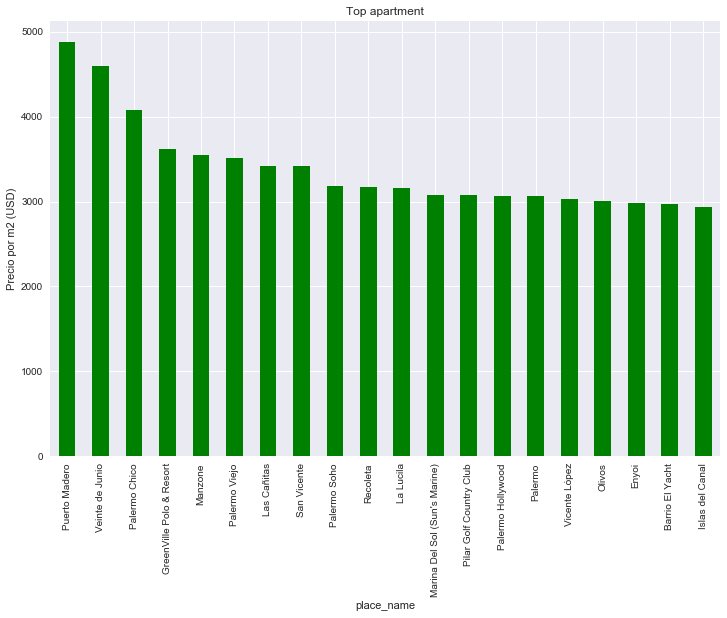

In [26]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='apartment'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top apartment')
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
plt.show()

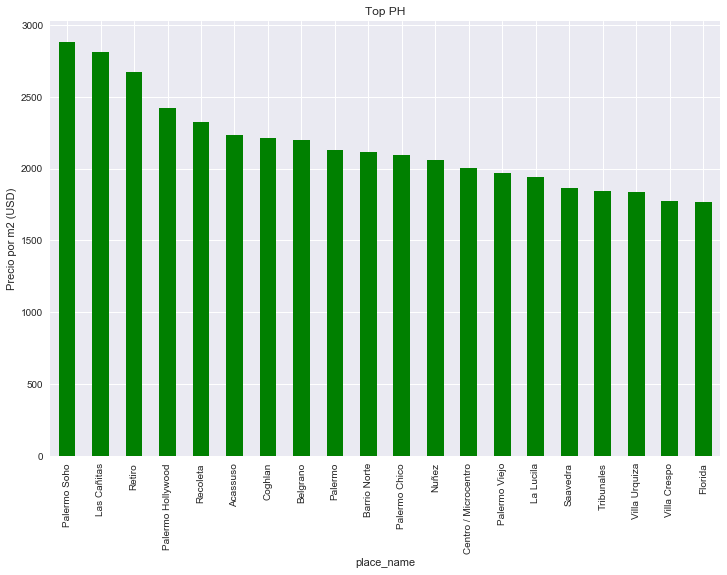

In [27]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='PH'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top PH')
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
plt.show()

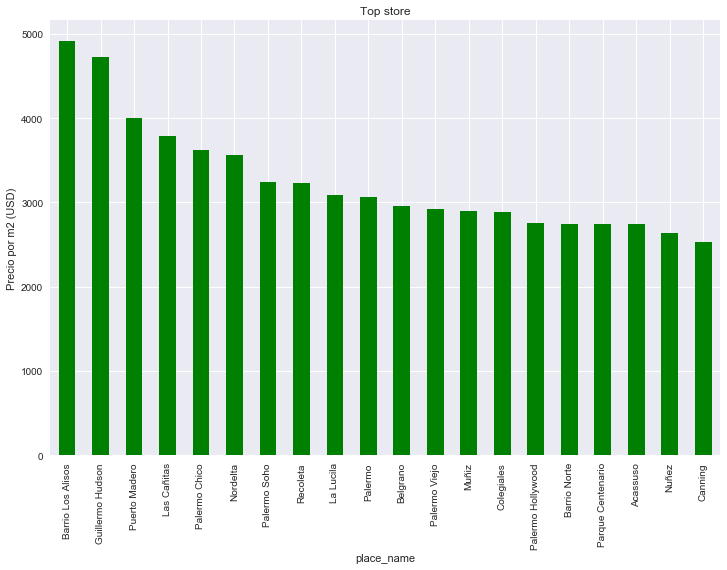

In [28]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='store'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top store')
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
plt.show()

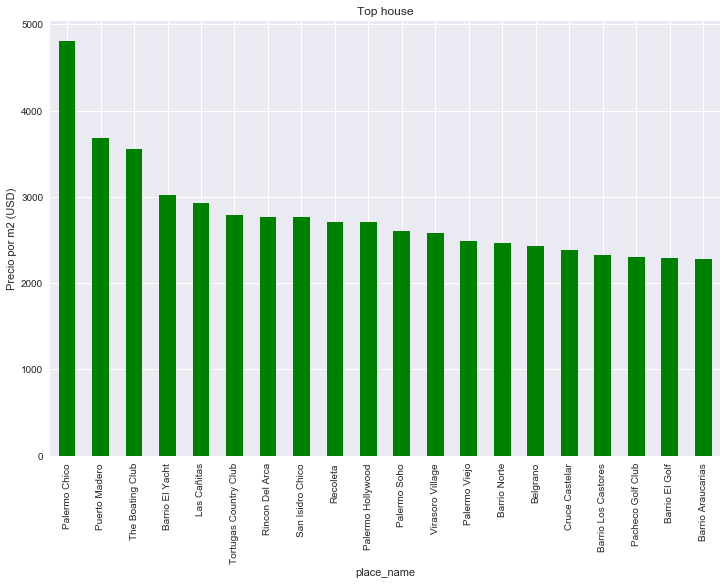

In [29]:
ranking_precios_usd = properati_filtrado.loc[properati_filtrado['property_type']=='house'].groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False).head(20)
ranking_precios_usd.plot(kind='bar',figsize=TAM_IMG,color='g')
plt.title('Top house')
plt.xlabel('place_name')
plt.ylabel('Precio por m2 (USD)')
plt.show()

In [30]:
propiedades_full=properati
propiedades_full.columns

Index([u'created_on', u'operation', u'property_type', u'place_name',
       u'place_with_parent_names', u'country_name', u'state_name',
       u'geonames_id', u'lat-lon', u'lat', u'lon', u'price', u'currency',
       u'price_aprox_local_currency', u'price_aprox_usd',
       u'surface_total_in_m2', u'surface_covered_in_m2', u'price_usd_per_m2',
       u'price_per_m2', u'floor', u'rooms', u'expenses', u'properati_url',
       u'description', u'title', u'image_thumbnail'],
      dtype='object')

In [31]:
properties_by_type=propiedades_full[['place_name','property_type']]


In [32]:
properties_by_type_and_total=properties_by_type.groupby('place_name').count().reset_index()

In [33]:
properties_by_type_and_total.columns=['place_name','total_properties']
properties_by_type_and_total

,place_name,total_properties
0,Country Maschwitz Club,189
1,los alamos,7
2,9 de Abril,8
3,Abasto,1223
4,Abril Club de Campo,256
5,Acacias Blancas,398
6,Acassuso,4279
7,Adrogué,4224
8,Aero Country Club,35
9,Aeropuerto Internacional Ezeiza,64


In [34]:
properties_by_type=properties_by_type.groupby('place_name').apply(lambda x: x['property_type'].value_counts()).reset_index()
properties_by_type=pd.pivot_table(properties_by_type,index=['place_name'],columns=['level_1']).reset_index()
properties_by_type

place_name property_type                    \
level_1                                                PH apartment   house   
0                    Country Maschwitz Club           NaN       NaN   189.0   
1                                los alamos           NaN       6.0     1.0   
2                                9 de Abril           NaN       NaN     6.0   
3                                    Abasto         137.0     880.0   114.0   
4                       Abril Club de Campo           NaN       NaN   256.0   
5                           Acacias Blancas           NaN       NaN   398.0   
6                                  Acassuso         105.0    1473.0  2444.0   
7                                   Adrogué         125.0    1163.0  2793.0   
8                         Aero Country Club           NaN      35.0     NaN   
9           Aeropuerto Internacional Ezeiza           NaN       NaN    64.0   
10                                Agronomía          99.0     527.0    61.0   
11                 Albanueva Barrio Cerrado           NaN      62.0    77.0   
12                               Aldo Bonzi          22.0      12.0   101.0   
13                           Alejandro Korn           NaN       1.0    71.0   
14                         Alejandro Petión           NaN       NaN    32.0   
15                                  Almagro        1003.0   11346.0   381.0   
16                          Almirante Brown          12.0      90.0   248.0   
17                                 Altamira           NaN       NaN    79.0   
18                        Altos de Hudson I           NaN       7.0     5.0   
19                       Altos de Hudson II           NaN      73.0    68.0   
20                Altos de Manzanares 1 y 2           NaN       NaN    38.0   
21                          Altos de Matheu           NaN       NaN    44.0   
22                           Altos del Golf           NaN       NaN    72.0   
23                          Altos del Pilar           NaN       NaN   113.0   
24                     Armenia Country Club           NaN       4.0    41.0   
25                             Arturo Seguí           NaN       NaN    26.0   
26                               Avellaneda         272.0    1990.0   420.0   
27                            Bahía del Sol           NaN       2.0    17.0   
28                                Balvanera         609.0    7273.0   189.0   
29                                 Banfield         281.0    1855.0  2094.0   
..                                      ...           ...       ...     ...   
587                          Villa Numancia           NaN       NaN     7.0   
588                           Villa Ortuzar          96.0     835.0    75.0   
589                           Villa Pacheco           NaN       NaN    25.0   
590                        Villa Pueyrredón         470.0    1281.0   428.0   
591                             Villa Raffo          43.0     219.0    73.0   
592                              Villa Real         157.0     187.0   159.0   
593                         Villa Riachuelo          20.0      13.0    30.0   
594                              Villa Rosa          16.0     416.0   513.0   
595                          Villa San Luis           NaN       NaN     4.0   
596                        Villa Santa Rita         143.0     647.0   190.0   
597                         Villa Sarmiento         337.0    1484.0  1348.0   
598                           Villa Soldati          32.0     138.0    22.0   
599                             Villa Tesei          38.0     124.0   368.0   
600                           Villa Udaondo          14.0       5.0  1056.0   
601                           Villa Urquiza        1106.0   10637.0   819.0   
602                          Villa Vatteone           5.0       1.0    18.0   
603                           Villa de Mayo           2.0     140.0   417.0   
604                        Villa del Parque         423.0    3124.0   549.0   
605 

In [35]:
 properties_by_type.columns=['place_name','PH','apartment','house','store']

In [36]:
properties_by_type_and_total=pd.merge(properties_by_type,properties_by_type_and_total,on = 'place_name', how='left')

In [37]:
properties_by_type_and_total_mean=properties_by_type_and_total

In [38]:
properties_by_type_and_total_mean=properties_by_type_and_total_mean.fillna(value=0)

In [39]:
properties_by_type_and_total_mean.loc[:,('apartment_percent')]=properties_by_type_and_total_mean['apartment']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('PH_percent')]=properties_by_type_and_total_mean['PH']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('house_percent')]=properties_by_type_and_total_mean['house']/properties_by_type_and_total_mean['total_properties']
properties_by_type_and_total_mean.loc[:,('store_percent')]=properties_by_type_and_total_mean['store']/properties_by_type_and_total_mean['total_properties']

In [40]:
properties_by_type_and_total_mean

,place_name,PH,apartment,house,store,total_properties,apartment_percent,PH_percent,house_percent,store_percent
0,Country Maschwitz Club,0.0,0.0,189.0,0.0,189,0.000000,0.000000,1.000000,0.000000
1,los alamos,0.0,6.0,1.0,0.0,7,0.857143,0.000000,0.142857,0.000000
2,9 de Abril,0.0,0.0,6.0,2.0,8,0.000000,0.000000,0.750000,0.250000
3,Abasto,137.0,880.0,114.0,92.0,1223,0.719542,0.112020,0.093213,0.075225
4,Abril Club de Campo,0.0,0.0,256.0,0.0,256,0.000000,0.000000,1.000000,0.000000
5,Acacias Blancas,0.0,0.0,398.0,0.0,398,0.000000,0.000000,1.000000,0.000000
6,Acassuso,105.0,1473.0,2444.0,257.0,4279,0.344239,0.024538,0.571161,0.060061
7,Adrogué,125.0,1163.0,2793.0,143.0,4224,0.275331,0.029593,0.661222,0.033854
8,Aero Country Club,0.0,35.0,0.0,0.0,35,1.000000,0.000000,0.000000,0.000000
9,Aeropuerto Internacional Ezeiza,0.0,0.0,64.0,0.0,64,0.000000,0.000000,1.000000,0.000000


In [41]:
properties_by_usd_m2=propiedades_full[['place_name','price_usd_per_m2']].dropna().groupby('place_name').mean().reset_index()

In [42]:
properties_by_m2_and_type_mean=pd.merge(properties_by_usd_m2,properties_by_type_and_total_mean,on='place_name',how='left')

In [43]:
properties_by_m2_and_type_mean_greater_than_20 = properties_by_m2_and_type_mean[properties_by_m2_and_type_mean['total_properties']>20]

In [44]:
properties_by_m2_and_type_mean_greater_than_20.loc[properties_by_m2_and_type_mean_greater_than_20['apartment_percent']< 0.5]['total_properties'].count()

356

## propiedades con patio y a estrenar

In [45]:
news_properties_with_garden=pd.DataFrame({'place_name':propiedades_full['place_name']\
                                          ,'description':propiedades_full['description'],'price_usd_per_m2':propiedades_full['price_usd_per_m2']})


In [46]:
news_properties_with_garden=news_properties_with_garden.dropna(how='any')

In [47]:
news_properties_with_garden.loc[:,'has_garden']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('patio')
news_properties_with_garden.loc[:,'is_new']=news_properties_with_garden.loc[:,'description'].str.lower().str.contains('estrenar')

In [48]:
news_properties_with_garden.sort_values(by='price_usd_per_m2',ascending=False).loc[:10]

,description,place_name,price_usd_per_m2,has_garden,is_new
791619,Popopopo - Publicado a traves de VisualGestion -,General Rodríguez,1271027.0,False,False
146115,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
233732,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
203127,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
97624,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
121298,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
73462,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
173628,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
613445,Popopopo - Publicado a traves de VisualGestion -,Capital Federal,1271027.0,False,False
491444,Departamento 1 ambiente divisible Depto en CU...,Boedo,206333.0,False,False


## Veamos cuales son las ciudades que vendieron más casas con patio

In [49]:
properties_total=propiedades_full[['place_name','property_type']]
#Calculo el total de las ventas por ciudad
properties_total=properties_total.groupby('place_name').count().reset_index()

In [50]:
properties_total.columns=['place_name','total']

In [51]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
properties_garden_count=news_properties_with_garden[['place_name','has_garden']][news_properties_with_garden['has_garden']]\
.groupby('place_name').count().reset_index()

In [52]:
#Merge entre cantidad de casas con jardines con cantidad total de casas
properties_garden_count=pd.merge(properties_garden_count,properties_total,on='place_name',how='left')

In [53]:
properties_garden_count.loc[:,('has_garden_percent')]=properties_garden_count['has_garden']/properties_garden_count['total']

In [54]:
#Elimino los datos con menores a 50 ventas.
properties_garden_count=properties_garden_count[properties_garden_count['total']>50]

In [55]:
properties_garden_count.sort_values(by='has_garden_percent',ascending=False)

,place_name,has_garden,total,has_garden_percent
307,Villa Libertad,159,248,0.641129
296,Villa Bonich,41,76,0.539474
57,Billinghurst,76,142,0.535211
211,Pablo Podestá,55,105,0.523810
150,José Ingenieros,29,63,0.460317
10,Altamira,34,79,0.430380
312,Villa Madero,212,523,0.405354
71,Carapachay,595,1503,0.395875
179,Los Hornos,74,195,0.379487
93,Crucecita,27,73,0.369863


## Mismo análisis con propiedades a estrenar

In [56]:
#Calculo la cantidad de casas con jardines vendidas por ciudad
news_properties_count=news_properties_with_garden[['place_name','is_new']][news_properties_with_garden['is_new']]\
.groupby('place_name').count().reset_index()
#Merge entre cantidad de casas a estrenar con cantidad total de casas
news_properties_count=pd.merge(news_properties_count,properties_total,on='place_name',how='left')


In [57]:
news_properties_count.loc[:,('is_new_percent')]=news_properties_count['is_new']/news_properties_count['total']

In [58]:
#Elimino los datos con menores a 50 ventas.
news_properties_count=news_properties_count[news_properties_count['total']>50]
news_properties_count.sort_values(by='is_new_percent',ascending=False)

,place_name,is_new,total,is_new_percent
154,La Angélica,47,74,0.635135
19,"Barrio Cerrado ""Ayres Plaza""",31,53,0.584906
141,Haras María Victoria,65,174,0.373563
107,El Canton Barrio Islas,31,84,0.369048
99,Crucecita,24,73,0.328767
254,Sáenz Peña,472,1444,0.326870
109,El Canton Barrio Puerto,30,102,0.294118
115,Enyoi,40,142,0.281690
16,Barrancas de San Jose,31,115,0.269565
108,El Canton Barrio Norte,32,123,0.260163


## Cual es el tipo de propiedad que se vende mas?  
#### Podria juntarse con el de abajo

In [59]:
top_tipos=properati_filtrado.groupby('property_type')['price'].count().sort_values()

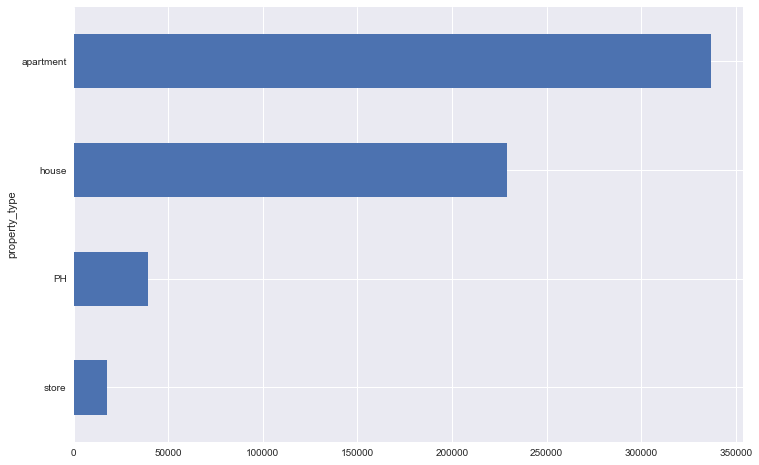

In [60]:
top_tipos.plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio de precio por tipo

In [61]:
promedio_por_tipo = properati_filtrado.groupby('property_type')['price_usd_per_m2'].mean()

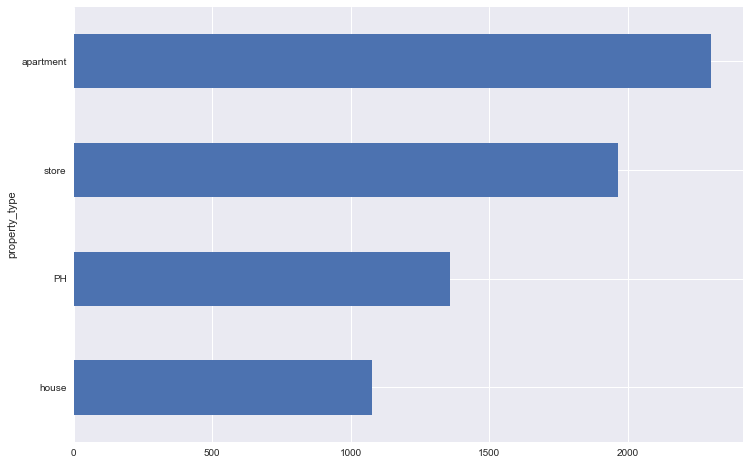

In [62]:
promedio_por_tipo.sort_values().plot(kind='barh',figsize=TAM_IMG)
#plt.set_ylabel('Tipo')
#plt.set_xlabel('Cantidad')
plt.show()

## Promedio precio por m2 por mes   <span style="color:red"> Arreglar para que diferencie los meses de los distintos años

In [63]:
promedio_por_tipo_y_mes = properati_filtrado.groupby(['property_type',properati_filtrado['created_on'].dt.month])['price_usd_per_m2'].mean().unstack(level=0)

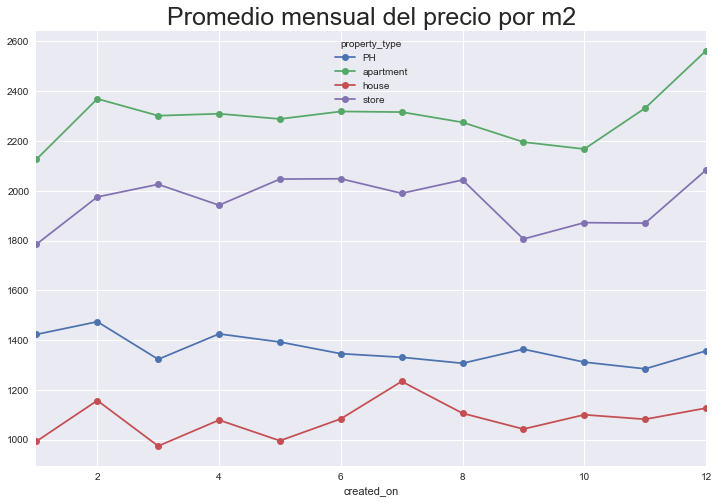

In [64]:
promedio_por_tipo_y_mes.plot(kind='line',marker="o",figsize=TAM_IMG)
plt.title('Promedio mensual del precio por m2',size=25)
plt.show()

##  Valor de las expensas vs el precio total

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


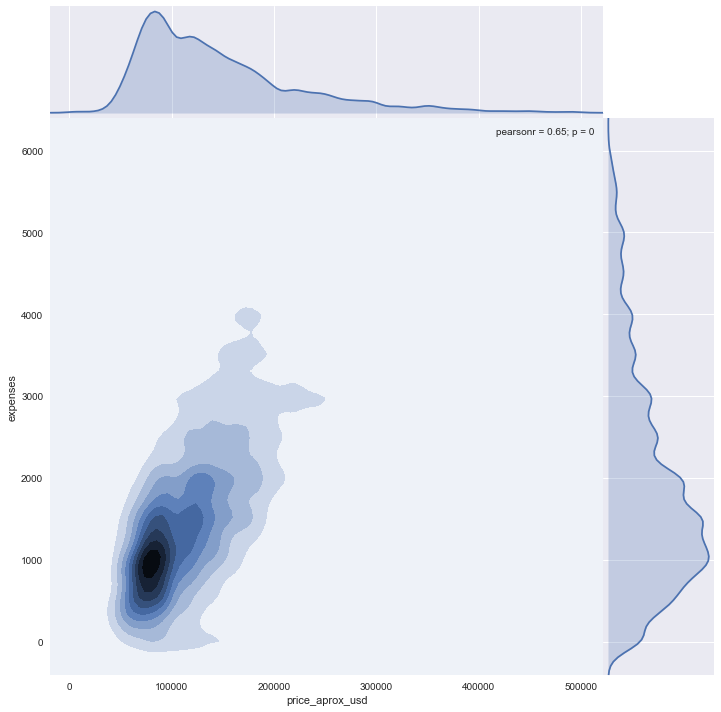

In [65]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.expenses<6000) & (properati_filtrado.expenses>0) & (properati_filtrado.price_aprox_usd <500000)].loc[:,('price_aprox_usd','expenses')].dropna() #hay unas expensas mal
sns.jointplot(x="price_aprox_usd", y="expenses", data=expensas_vs_precio, kind="kde",size=10, space=0)
plt.show()

##  Valor de las expensas vs el precio por m2

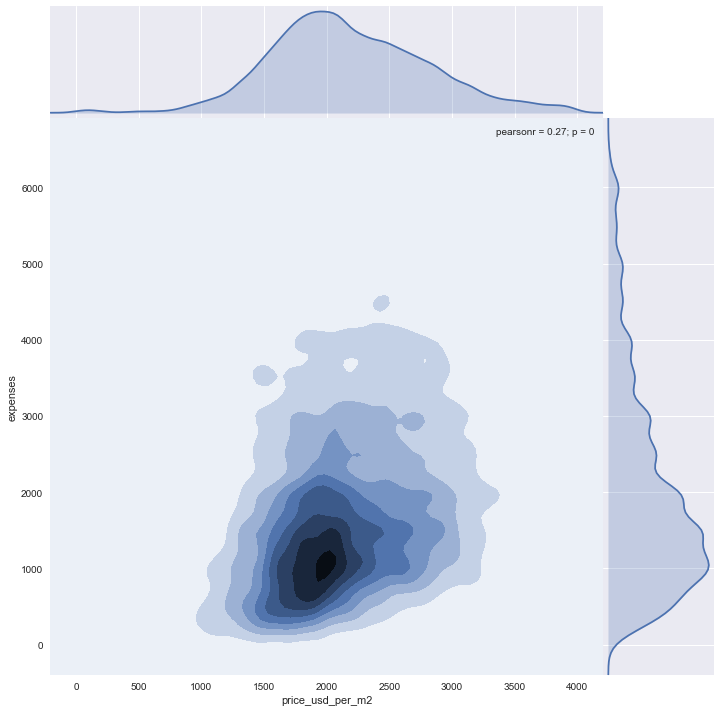

In [107]:
expensas_vs_precio = properati_filtrado.loc[(properati_filtrado['property_type'] == 'apartment') & (properati_filtrado.price_usd_per_m2<4000) & (properati_filtrado.expenses>50) & (properati_filtrado.expenses<6500)].loc[:,('price_usd_per_m2','expenses')].dropna() #hay unas expensas mal
sns.jointplot(x="price_usd_per_m2", y="expenses", data=expensas_vs_precio, kind="kde",size=10, space=0)
plt.show()

##  Supeficie descubierta vs precio 

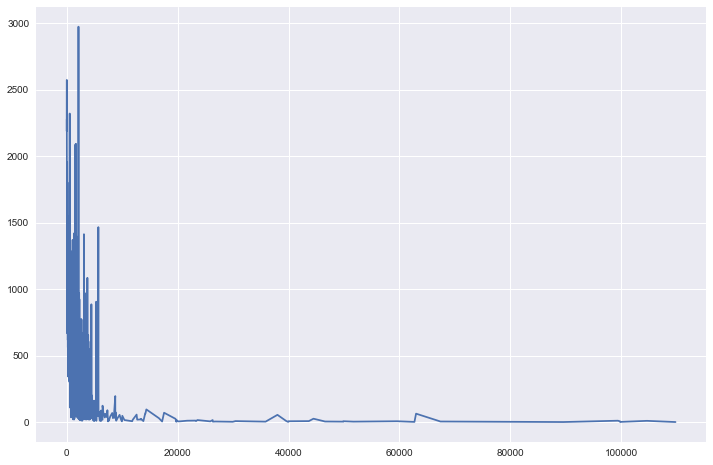

In [102]:
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado['surface_total_in_m2'] - properati_filtrado['surface_covered_in_m2']
properati_filtrado.loc[:,'superficie_descubierta'] = properati_filtrado.loc[properati_filtrado.superficie_descubierta>0 & ((properati_filtrado.property_type == "PH")|(properati_filtrado.property_type == "apartment"))]
precio_vs_descubierto= properati_filtrado.loc[:,('price_usd_per_m2','superficie_descubierta')].dropna()
precio_vs_descubierto = precio_vs_descubierto.groupby('superficie_descubierta').mean()

plt.figure(figsize=TAM_IMG)
plt.plot(precio_vs_descubierto)
plt.show()

##  Precio por m2 vs habitaciones

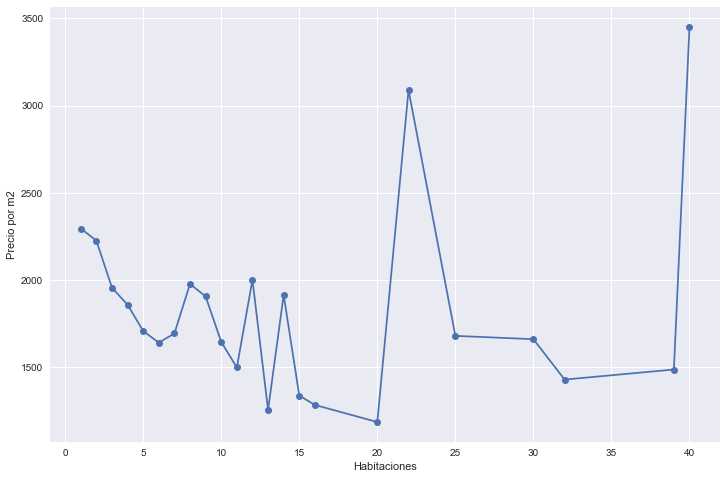

In [103]:
precio_vs_habs= properati_filtrado.loc[:,('price_usd_per_m2','rooms')].dropna()
precio_vs_habs= precio_vs_habs.groupby('rooms').mean()

plt.figure(figsize=TAM_IMG)
plt.xlabel('Habitaciones')
plt.ylabel('Precio por m2')
plt.plot(precio_vs_habs,marker="o")
plt.show()

## Precio m2 vs años para cada tipo

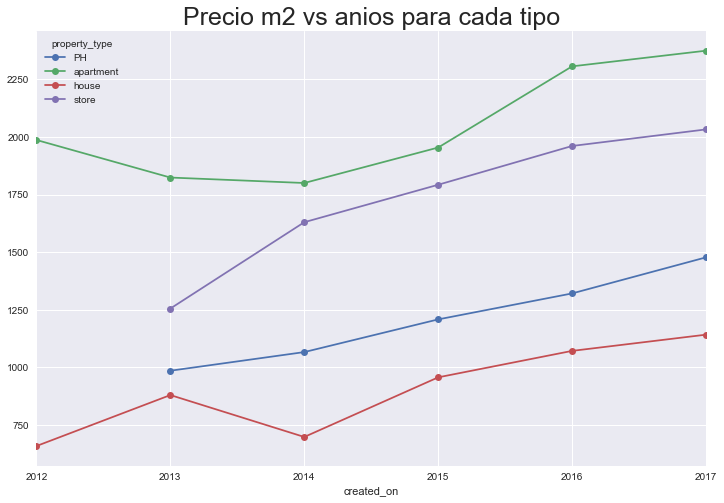

In [104]:
m2_anual = properati_filtrado.groupby([properati_filtrado.property_type,properati_filtrado.created_on.dt.year]).mean()['price_usd_per_m2'].unstack(level=0)
m2_anual.plot(kind='line',marker="o",figsize=TAM_IMG)
plt.title('Precio m2 vs anios para cada tipo',size=25)
plt.show()

##  Piso del departamento vs precio por m2

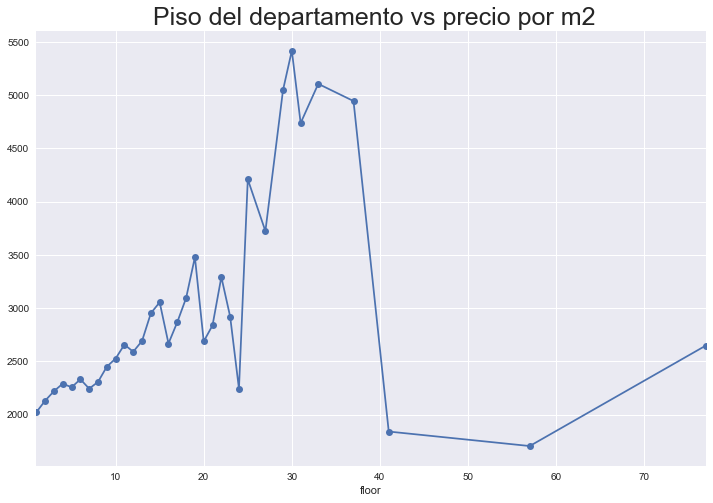

In [105]:
piso_vs_precio = properati_filtrado.loc[:,('price_usd_per_m2','floor')].dropna()
piso_vs_precio = piso_vs_precio.loc[piso_vs_precio.floor < 100]
piso_vs_precio = piso_vs_precio.groupby(properati_filtrado.floor)
piso_vs_precio = piso_vs_precio.mean()['price_usd_per_m2']
piso_vs_precio.plot(kind='line',marker="o",figsize=TAM_IMG)
plt.title(' Piso del departamento vs precio por m2',size=25)
plt.show()

##  Piso del departamento vs expensas

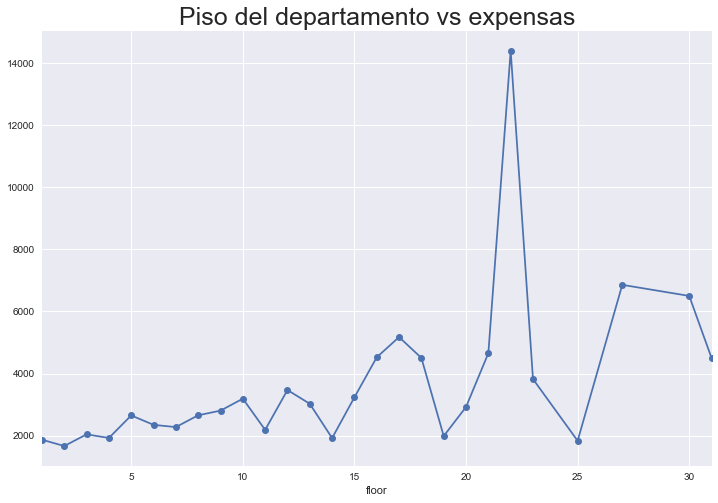

In [106]:
piso_vs_expensas = properati_filtrado.loc[:,('floor','expenses')].dropna(subset=['expenses'])
piso_vs_expensas = piso_vs_expensas.loc[properati_filtrado.floor <50]
piso_vs_expensas = piso_vs_expensas.groupby(properati_filtrado.floor).mean()['expenses']
piso_vs_expensas.plot(kind='line',marker="o",figsize=TAM_IMG)
plt.title('Piso del departamento vs expensas',size=25)
plt.show()

# <span style="color:red"> Poner nombre a ejes de graficos y refactorizar. Insertar columnas adicionales como a estrenar, con jardin, con gimnasio en dataframe principal

In [91]:
caba = properati_filtrado.loc[properati_filtrado.state_name == 'Capital Federal']

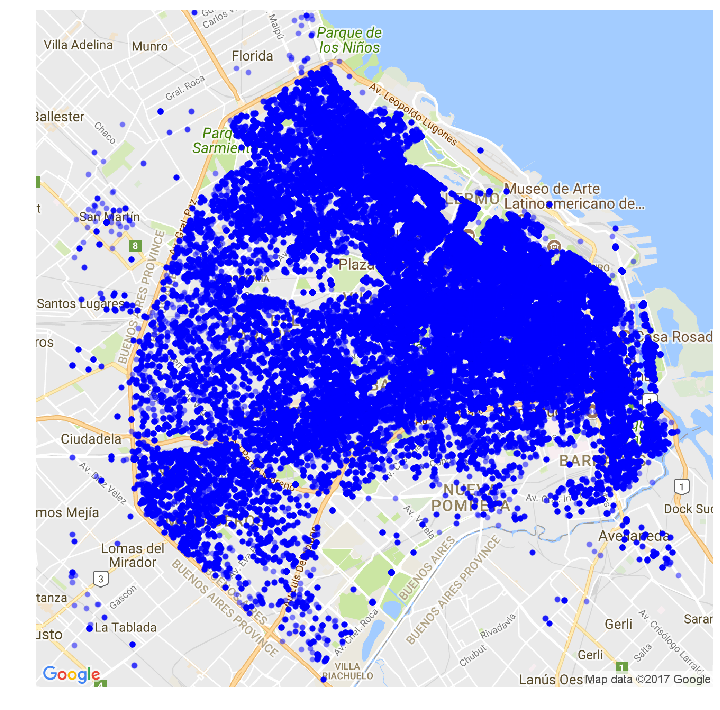

In [92]:
caba_para_mapa = caba_para_mapa.dropna(subset= ['lat','lon'])
caba_para_mapa = caba_para_mapa.loc[(caba_para_mapa.lat > -35) & (caba_para_mapa.lat < -34) & (caba_para_mapa.lon > -58.7)]
gp.scatter(caba_para_mapa['lat'], caba_para_mapa['lon'],colors='blue')

In [93]:
subtes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-subte.csv')

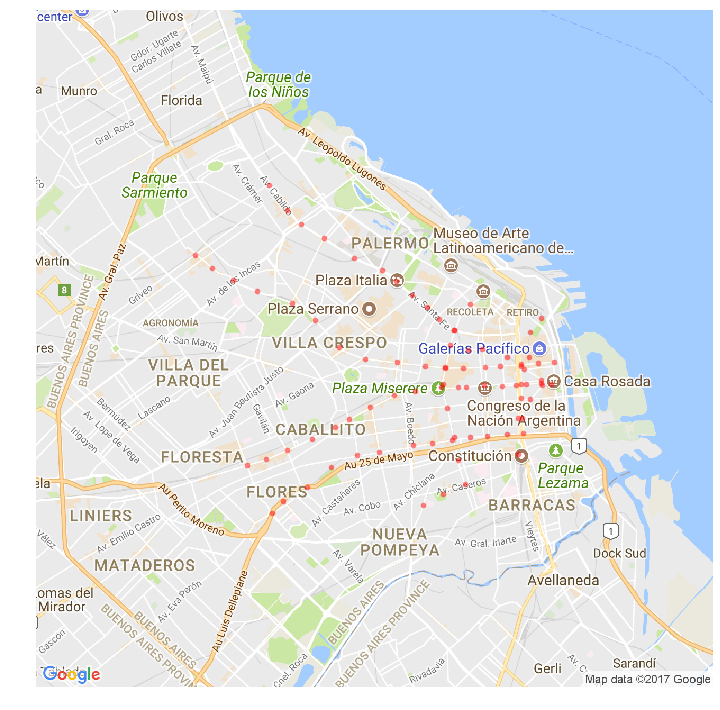

In [100]:
gp.scatter(subtes['Y'], subtes['X'],colors='red')

In [122]:
colectivos = pd.read_csv('datos/datasets/CABA/latlon/paradas-de-colectivo.csv')

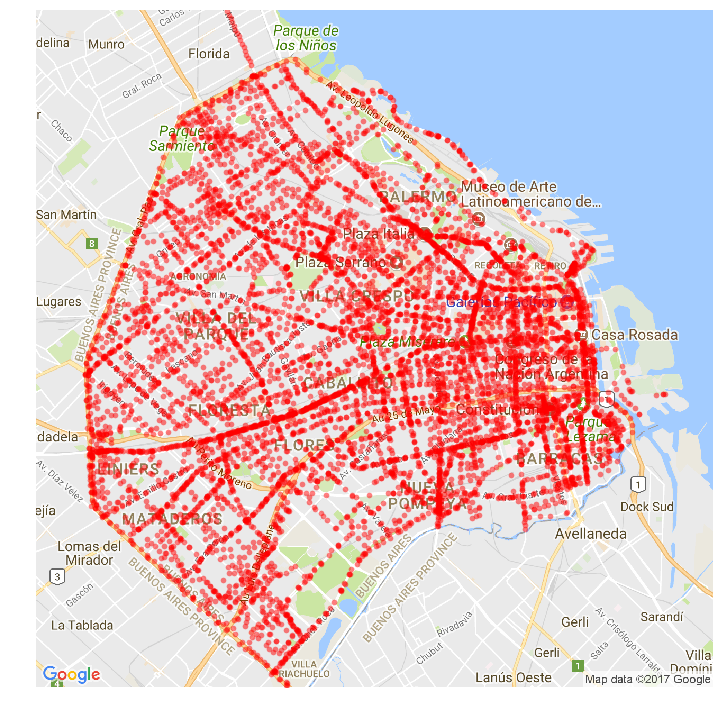

In [121]:
gp.scatter(colectivos['Y'], colectivos['X'],colors='red')

In [132]:
metrobus = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-metrobus.csv')

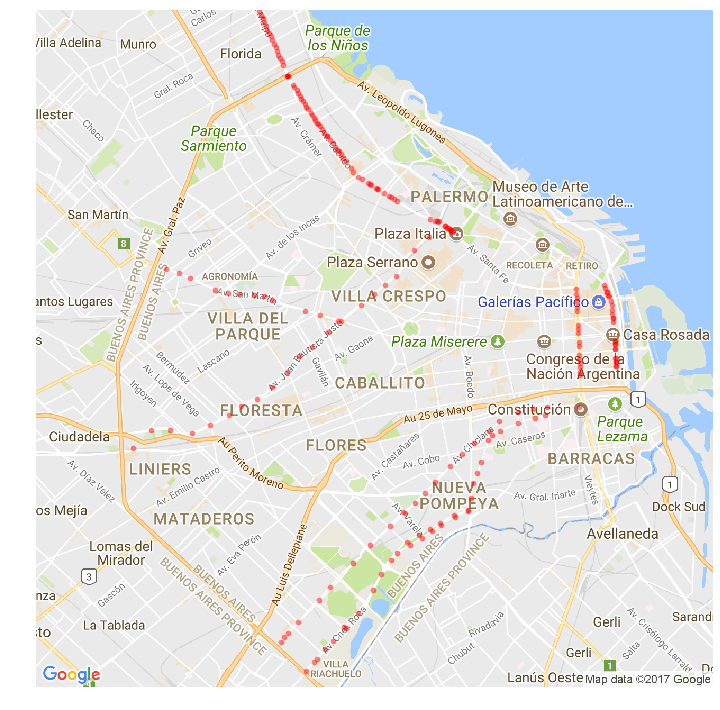

In [130]:
gp.scatter(metrobus['Y'], metrobus['X'],colors='red')

In [147]:
trenes = pd.read_csv('datos/datasets/CABA/latlon/estaciones-de-ferrocarril.csv',error_bad_lines=False)

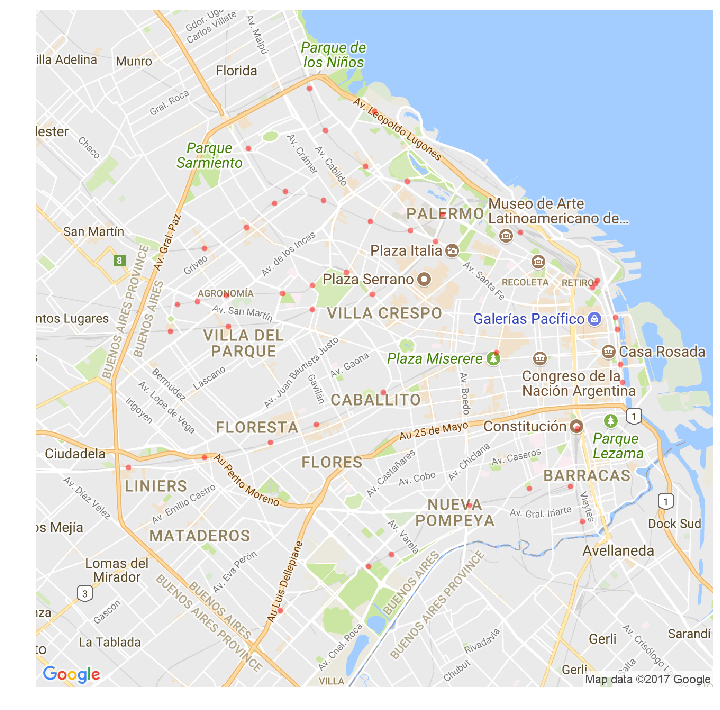

In [148]:
gp.scatter(trenes['LAT'], trenes['LNG'],colors='red')